In [1]:
import os
import pandas as pd
import skimage as sk
from skimage import io as skio, transform
import numpy as np
import matplotlib.pyplot as plt
from cpselect.cpselect import cpselect
import json
import cv2
from harris import get_harris_corners

/Users/vananish/Documents/Berkeley/CS194/Proj5/cs194-proj5a/harris.py:50: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(dimx == dimc, 'Data dimension does not match dimension of centers')


In [121]:
# Part A
# Digitizing Shelf Pictures and generating points

shelf1 = skio.imread('shelf1.jpg', as_gray=True)
shelf2 = skio.imread('shelf2.jpg', as_gray=True)

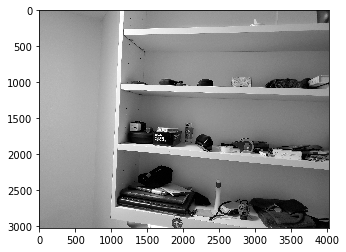

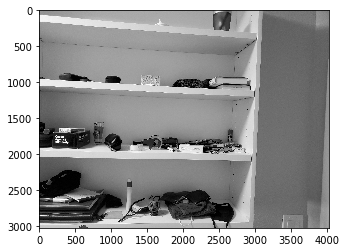

In [3]:
plt.figure()
plt.imshow(shelf2, cmap='gray')
plt.show()
plt.imshow(shelf1, cmap='gray')
plt.show()

In [5]:
# controlpointlist = cpselect("shelf1.jpg", "shelf2.jpg")


In [111]:
with open('shelf_pts.json') as jsonfile:
    controlpointlist = json.load(jsonfile)

In [5]:
# Append 1 to each pts tuple
shelf1_pts = []
shelf2_pts = []
for i in controlpointlist:
    shelf1_pts.append([i['img1_x'], i['img1_y'], 1])
    shelf2_pts.append([i['img2_x'], i['img2_y'], 1])
shelf1_pts = np.array(shelf1_pts)
shelf2_pts = np.array(shelf2_pts)

In [5]:
# I referenced this stackoverflow post https://stackoverflow.com/questions/61146241/how-to-stitch-two-images-using-homography-matrix-in-opencv
# Computing the homography
def compute_h(pts_1, pts_2):
    temp = []
    for i in range(len(pts_1)):
        x_1, x_2 = pts_1[i][0], pts_2[i][0]
        y_1, y_2 = pts_1[i][1], pts_2[i][1]
        temp.append([x_1, y_1, 1, 0, 0, 0, -x_1 * x_2, -x_2 * y_1, -x_2])
        temp.append([0, 0, 0, x_1, y_1, 1, -y_2 * x_1, -y_2 * y_1, -y_2])
    temp = np.asarray(temp)
    U, S, V = np.linalg.svd(temp)
    L = V[-1, :] / V[-1, -1]
    H = L.reshape(3, 3)
    return H

In [72]:
H = compute_h(shelf2_pts, shelf1_pts)
print(H)

[[ 1.65781872e+00  5.96527612e-02 -2.49110433e+03]
 [ 2.11424109e-01  1.49582994e+00 -6.75666637e+02]
 [ 1.56687524e-04  1.69952396e-05  1.00000000e+00]]


In [25]:
print(cv2.findHomography(shelf2_pts, shelf1_pts)[0])

[[ 1.62781409e+00  4.98600199e-02 -2.42710027e+03]
 [ 2.01740367e-01  1.46273256e+00 -6.34987050e+02]
 [ 1.51560690e-04  1.17294320e-05  1.00000000e+00]]


In [26]:
print(shelf1.shape)

(3024, 4032)


In [6]:
# Warp the image

def warpImage(im, H):
    h, w = im.shape[:2]
    w += w
    y_indices, x_indices = np.indices((h, w), dtype=np.float32)
    # Flattening into an array
    flat_ind = np.array([x_indices.flatten(), y_indices.flatten(), np.ones(x_indices.shape).flatten()])
    map_ind = np.dot(H, flat_ind)
    map_x, map_y = map_ind[:-1]/map_ind[-1]
    map_x = map_x.reshape(h, w).astype(np.float32)
    map_y = map_y.reshape(h, w).astype(np.float32)
    # Referred to STO for info on using the remap fn https://stackoverflow.com/questions/46520123/how-do-i-use-opencvs-remap-function
    warp = cv2.remap(im, map_x, map_y, cv2.INTER_LINEAR)
    return warp


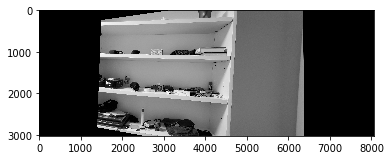

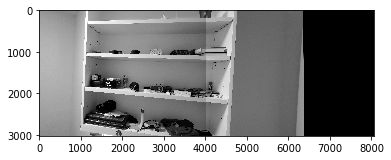

In [123]:
# Warp the images and generate the mosaic
im_warped = warpImage(shelf1, H)
plt.figure()
plt.imshow(im_warped, cmap='gray')
plt.show()
im_warped[0:shelf2.shape[0], 0:shelf2.shape[1]] = shelf2
# im_warped[:, 1500:4000] = im_warped[:,1500:4000]/2
plt.imshow(im_warped, cmap='gray')
plt.show()

In [116]:
# # Compared with cv2.warpPrespective
# im_warped = cv2.warpPerspective(shelf2, H, (4032+4032, 3024))
# plt.figure()
# plt.imshow(im_warped, cmap='gray')
# plt.show()
# im_warped[0:shelf2.shape[0], 0:shelf2.shape[1]] = shelf1
# plt.imshow(im_warped, cmap='gray')
# plt.show()

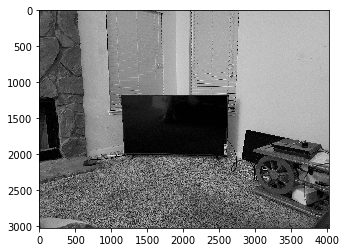

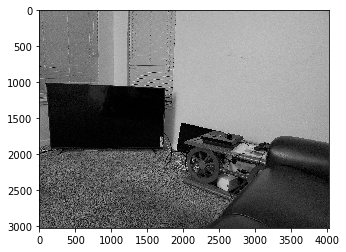

In [3]:
# Mosaic with some more images
tv1 = skio.imread('tv1.jpg', as_gray=True)
tv2 = skio.imread('tv2.jpg', as_gray=True)
plt.figure()
plt.imshow(tv2, cmap='gray')
plt.show()
plt.imshow(tv1, cmap='gray')
plt.show()

In [2]:
controlpointlist = cpselect("tv1.jpg", "tv2.jpg")


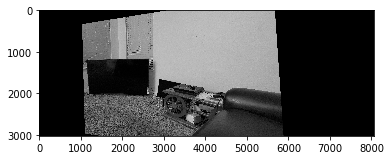

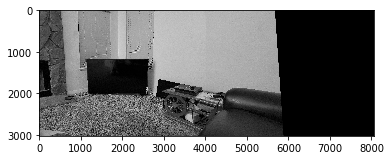

In [7]:
with open('tv_pts.json') as jsonfile:
    controlpointlist = json.load(jsonfile)
# Append 1 to each pts tuple
tv1_pts = []
tv2_pts = []
for i in controlpointlist:
    tv1_pts.append([i['img1_x'], i['img1_y'], 1])
    tv2_pts.append([i['img2_x'], i['img2_y'], 1])
tv1_pts = np.array(tv1_pts)
tv2_pts = np.array(tv2_pts)
H_tv = compute_h(tv2_pts, tv1_pts)

# Warp the images and generate the mosaic
im_warped_tv = warpImage(tv1, H_tv)
plt.figure()
plt.imshow(im_warped_tv, cmap='gray')
plt.show()
im_warped_tv[0:tv2.shape[0], 0:tv2.shape[1]] = tv2
plt.imshow(im_warped_tv, cmap='gray')
plt.show()

hhher
(2, 1732)


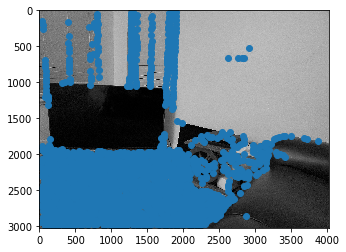

In [9]:
# Part B
# 1. Detecting corner features in an image

tv1_h_arr, tv1_h_corners = get_harris_corners(tv1)
print(tv1_h_corners.shape)
plt.plot(tv1_h_corners[:][1], tv1_h_corners[:][0], 'o')
plt.imshow(tv1, cmap='gray')